In [1]:
import pandas as pd
import seaborn as sns
import re,json,nltk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.filterwarnings("ignore")
import os

In [2]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/6-class-bert-preprocessed-dataset/Bert_Preprocessed_Dataset.xlsx


In [4]:
df=pd.read_excel('/kaggle/input/6-class-bert-preprocessed-dataset/Bert_Preprocessed_Dataset.xlsx')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6405 entries, 0 to 6404
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6405 non-null   int64 
 1   ID          6404 non-null   object
 2   Text        6404 non-null   object
 3   Sentiment   6405 non-null   object
 4   Label       6405 non-null   int64 
 5   Token       6405 non-null   object
 6   Token_ID    6405 non-null   object
dtypes: int64(2), object(5)
memory usage: 350.4+ KB


In [5]:
df.head()

,Unnamed: 0,ID,Text,Sentiment,Label,Token,Token_ID
0,479,939195189512152_939206382844366,উনারে লাথথায়ে মিরপুর চিড়িয়াখানার প্রধান সিকিউর...,angry,0,"['উনার', '##ে', 'লা', '##থ', '##থা', '##যে', '...","[36081, 2094, 3853, 7740, 12969, 8844, 15638, ..."
1,1750,935156429916028_935165096581828,কই এখন আপনি লেকচার থেমে গেল কেন ভাই,angry,0,"['কই', 'এখন', 'আপনি', 'লেকচার', 'থেমে', 'গেল',...","[6852, 2112, 2536, 22174, 3214, 2590, 2304, 2570]"
2,1855,987743164678331_1529633654011820,সুন্দর জোক্স,happy,3,"['সনদ', '##র', 'জে', '##াক', '##স']","[5391, 2046, 4803, 15547, 2388]"
3,1382,935324716565866_935576566540681,বেশির ভাগ ক্ষেত্রে যাত্রী গন কম ভুল করে আর বেশ...,sad,4,"['বেশির', 'ভাগ', 'কষে', '##তর', '##ে', 'যা', '...","[3217, 2516, 19675, 12499, 2094, 2120, 42396, ..."
4,3388,987743164678331_552808888211836,বাংলাদেশের হিন্দু মুসলিম সবাই ভাই ভাই যে অন্যন...,sad,4,"['বাংলাদেশের', 'হিন', '##দ', 'মস', '##লিম', 'স...","[2119, 50082, 5718, 23143, 33783, 2553, 2570, ..."


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

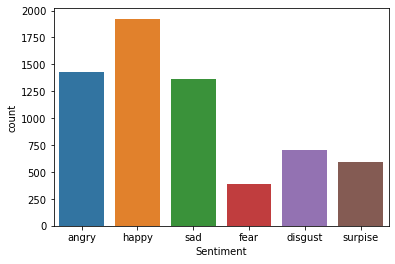

In [6]:
sns.countplot(df['Sentiment'])

In [7]:
df.Sentiment.value_counts(), len(df)

(happy      1924
 angry      1427
 sad        1366
 disgust     704
 surpise     592
 fear        392
 Name: Sentiment, dtype: int64,
 6405)

In [8]:
df=df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [9]:
df.reset_index(drop=True, inplace=True)

In [10]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear','sigmoid'],
            'gamma':['auto','scale'],
            'decision_function_shape':['ovo', 'ovr']

        }  
    },
    
    'decision tree':{
        'model':DecisionTreeClassifier(),
        'params':{
            'max_depth' : [125,500,700,900],
            'max_features' : ["sqrt","log2"],
            'min_samples_split' : [15,55,95],
            'criterion':['entropy']
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10,25],
            #'weights': ['uniform','distance']
            
        }
    },
    'multinomial naive bayes':{
        'model':MultinomialNB(),
        'params':{
            'alpha':[.10,.25,.40,.75,.90]
        }
    },
    'k nearest neighbors':{
        'model':KNeighborsClassifier(),
        'params':{
            'n_neighbors': [3,4,5,6,7],
            'weights': ['uniform','distance'], 
            'algorithm' : ['ball_tree', 'kd_tree', 'brute']

            
        }
    },
    'Stochastic Gradient Descent':{
        'model':SGDClassifier(),
        'params':{
            'loss':['log'],
            'penalty':['l2', 'l1', 'elasticnet'], 
            'alpha':[.0001,.0005,.0009,.0012]

        }
    }
}

In [11]:
scores_function = ['precision_macro','recall_macro','f1','accuracy']

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
x_bow = vect.fit_transform(df['Token'])
x_train, x_test, y_train, y_test = train_test_split(x_bow,df['Label'], test_size=0.2, random_state=42)

In [13]:
categories=[0,1,2,3,4,5]

In [14]:
scores = []
for model_name, mp in model_params.items():
  for score in scores_function:
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, scoring=score)
    clf.fit(x_train,y_train)
    
  scores.append({
            'model': model_name,
            'best_params': clf.best_params_,
            'precision':precision_score(y_test,clf.predict(x_test),average='macro'),
            'recall':recall_score(y_test,clf.predict(x_test),average='macro'),
            'f1':f1_score(y_test,clf.predict(x_test),average='macro'),
            'accuracy':accuracy_score(y_test,clf.predict(x_test))
        })
    
df_score = pd.DataFrame(scores,columns=['model','best_params','precision','recall','f1','accuracy'])
df_score.to_excel('6 classes BOW ML parameters.xlsx')
df_score.sort_values(by=['accuracy'],ascending=False) 


,model,best_params,precision,recall,f1,accuracy
0,svm,"{'C': 1, 'decision_function_shape': 'ovo', 'ga...",0.374807,0.282199,0.242649,0.427010
5,Stochastic Gradient Descent,"{'alpha': 0.0012, 'loss': 'log', 'penalty': 'l2'}",0.310548,0.279214,0.252683,0.415301
2,logistic_regression,{'C': 1},0.300345,0.288486,0.275296,0.412178
3,multinomial naive bayes,{'alpha': 0.9},0.266149,0.278285,0.257591,0.409836
4,k nearest neighbors,"{'algorithm': 'ball_tree', 'n_neighbors': 7, '...",0.265685,0.253522,0.237695,0.370023
1,decision tree,"{'criterion': 'entropy', 'max_depth': 125, 'ma...",0.227817,0.234685,0.215067,0.349727


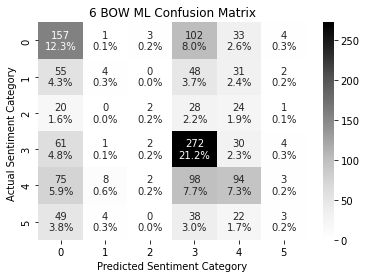

In [16]:
y_pred=clf.best_estimator_.predict(x_test)
y_pred = y_pred.reshape(-1,1)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.1%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(6,6)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greys')

ax.set_title('6 BOW ML Confusion Matrix');
ax.set_xlabel('Predicted Sentiment Category')
ax.set_ylabel('Actual Sentiment Category ');

ax.xaxis.set_ticklabels([0,1,2,3,4,5])
ax.yaxis.set_ticklabels([0,1,2,3,4,5])
sns.set(color_codes=True)
sns.set(font_scale=.8)
plt.savefig('6 BOW ML Confusion Matrix', bbox_inches = "tight")
plt.show()

In [17]:
#TF-IDF unigram
tfidf_unigram = TfidfVectorizer(use_idf=True,tokenizer=lambda x: x.split()) 
x_tfidf_unigram= tfidf_unigram.fit_transform(df['Token'])
x_train, x_test, y_train, y_test = train_test_split(x_tfidf_unigram,df['Label'], test_size=0.2, random_state=42)

In [18]:
scores = []
for model_name, mp in model_params.items():
  for score in scores_function:
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, scoring=score)
    clf.fit(x_train,y_train)
    
  scores.append({
            'model': model_name,
            'best_params': clf.best_params_,
            'precision':precision_score(y_test,clf.predict(x_test),average='macro'),
            'recall':recall_score(y_test,clf.predict(x_test),average='macro'),
            'f1':f1_score(y_test,clf.predict(x_test),average='macro'),
            'accuracy':accuracy_score(y_test,clf.predict(x_test))
        })
    
df_score = pd.DataFrame(scores,columns=['model','best_params','precision','recall','f1','accuracy'])
df_score.to_excel('6 classes TF-IDF unigram ML parameters.xlsx')
df_score.sort_values(by=['accuracy'],ascending=False) 


,model,best_params,precision,recall,f1,accuracy
0,svm,"{'C': 10, 'decision_function_shape': 'ovo', 'g...",0.483476,0.364040,0.351387,0.512100
2,logistic_regression,{'C': 1},0.410965,0.347005,0.317115,0.509758
5,Stochastic Gradient Descent,"{'alpha': 0.0001, 'loss': 'log', 'penalty': 'e...",0.411110,0.356384,0.337434,0.508197
3,multinomial naive bayes,{'alpha': 0.25},0.417275,0.336138,0.296172,0.501952
4,k nearest neighbors,"{'algorithm': 'ball_tree', 'n_neighbors': 7, '...",0.325399,0.326851,0.316902,0.459797
1,decision tree,"{'criterion': 'entropy', 'max_depth': 125, 'ma...",0.276085,0.268693,0.260397,0.373146


In [19]:
#TF-IDF unigram
tfidf_unigram = TfidfVectorizer(use_idf=True,tokenizer=lambda x: x.split()) 
x_tfidf_unigram= tfidf_unigram.fit_transform(df['Text'])
x_train, x_test, y_train, y_test = train_test_split(x_tfidf_unigram,df['Label'], test_size=0.2, random_state=42)

In [20]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(x_train,y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_score = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_score.sort_values(by=['best_score'],ascending=False) 

,model,best_score,best_params
0,svm,0.506444,"{'C': 10, 'decision_function_shape': 'ovo', 'g..."
5,Stochastic Gradient Descent,0.501956,"{'alpha': 0.0001, 'loss': 'log', 'penalty': 'l2'}"
2,logistic_regression,0.500784,{'C': 5}
3,multinomial naive bayes,0.493165,{'alpha': 0.1}
4,k nearest neighbors,0.451774,"{'algorithm': 'ball_tree', 'n_neighbors': 7, '..."
1,decision tree,0.398285,"{'criterion': 'entropy', 'max_depth': 700, 'ma..."


In [21]:
y_pred=clf.best_estimator_.predict(x_test)
y_pred = y_pred.reshape(-1,1)
print('6 Unigram Classification Report TF-IDF Unigram')
print(classification_report(y_test,y_pred))

6 Unigram Classification Report TF-IDF Unigram
              precision    recall  f1-score   support

           0       0.50      0.62      0.55       300
           1       0.36      0.06      0.10       140
           2       0.38      0.04      0.07        75
           3       0.59      0.81      0.68       370
           4       0.39      0.47      0.43       280
           5       0.35      0.12      0.18       116

    accuracy                           0.50      1281
   macro avg       0.43      0.35      0.34      1281
weighted avg       0.47      0.50      0.45      1281



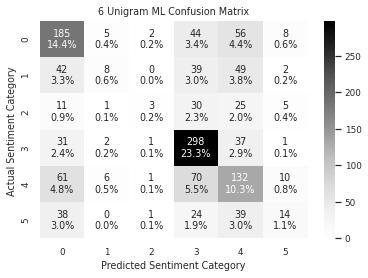

In [23]:
y_pred=clf.best_estimator_.predict(x_test)
y_pred = y_pred.reshape(-1,1)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.1%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(6,6)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greys')

ax.set_title('6 Unigram ML Confusion Matrix');
ax.set_xlabel('Predicted Sentiment Category')
ax.set_ylabel('Actual Sentiment Category ');

ax.xaxis.set_ticklabels([0,1,2,3,4,5])
ax.yaxis.set_ticklabels([0,1,2,3,4,5])
sns.set(color_codes=True)
sns.set(font_scale=.8)
plt.savefig('6 unigram Confusion Matrix', bbox_inches = "tight")
plt.show()

In [24]:
# TF-IDF Bigram
tfidf_bigram = TfidfVectorizer(ngram_range=(1,2),use_idf=True,tokenizer=lambda x: x.split()) 
x_tfidf_bigram = tfidf_bigram.fit_transform(df['Token'])
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_tfidf_bigram,df['Label'], test_size=0.2, random_state=42)

In [25]:
scores = []
for model_name, mp in model_params.items():
  for score in scores_function:
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, scoring=score)
    clf.fit(x_train,y_train)
    
  scores.append({
            'model': model_name,
            'best_params': clf.best_params_,
            'precision':precision_score(y_test,clf.predict(x_test),average='macro'),
            'recall':recall_score(y_test,clf.predict(x_test),average='macro'),
            'f1':f1_score(y_test,clf.predict(x_test),average='macro'),
            'accuracy':accuracy_score(y_test,clf.predict(x_test))
        })
    
df_score = pd.DataFrame(scores,columns=['model','best_params','precision','recall','f1','accuracy'])
df_score.to_excel('6 classes TF-IDF Bigram ML parameters.xlsx')
df_score.sort_values(by=['accuracy'],ascending=False) 

,model,best_params,precision,recall,f1,accuracy
2,logistic_regression,{'C': 25},0.431921,0.373937,0.365936,0.517564
0,svm,"{'C': 1, 'decision_function_shape': 'ovo', 'ga...",0.488796,0.354965,0.332006,0.511319
5,Stochastic Gradient Descent,"{'alpha': 0.0001, 'loss': 'log', 'penalty': 'l2'}",0.389219,0.343958,0.310236,0.509758
3,multinomial naive bayes,{'alpha': 0.1},0.453443,0.346808,0.319738,0.506635
4,k nearest neighbors,"{'algorithm': 'ball_tree', 'n_neighbors': 7, '...",0.364678,0.356536,0.352843,0.472287
1,decision tree,"{'criterion': 'entropy', 'max_depth': 700, 'ma...",0.276318,0.274302,0.260662,0.392662


In [26]:
y_pred=clf.best_estimator_.predict(x_test)
y_pred = y_pred.reshape(-1,1)
print('6 Bigram Classification Report TF-IDF ')
print(classification_report(y_test,y_pred))

6 Bigram Classification Report TF-IDF 
              precision    recall  f1-score   support

           0       0.52      0.59      0.56       300
           1       0.33      0.02      0.04       140
           2       0.00      0.00      0.00        75
           3       0.58      0.86      0.69       370
           4       0.40      0.52      0.45       280
           5       0.50      0.07      0.12       116

    accuracy                           0.51      1281
   macro avg       0.39      0.34      0.31      1281
weighted avg       0.46      0.51      0.44      1281



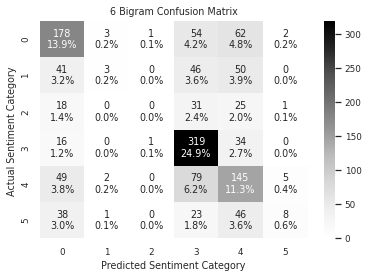

In [27]:
y_pred=clf.best_estimator_.predict(x_test)
y_pred = y_pred.reshape(-1,1)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.1%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(6,6)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greys')

ax.set_title('6 Bigram Confusion Matrix');
ax.set_xlabel('Predicted Sentiment Category')
ax.set_ylabel('Actual Sentiment Category ');

ax.xaxis.set_ticklabels([0,1,2,3,4,5])
ax.yaxis.set_ticklabels([0,1,2,3,4,5])
sns.set(color_codes=True)
sns.set(font_scale=.8)
plt.savefig('6 Bigram Confusion Matrix', bbox_inches = "tight")
plt.show()

In [28]:
#TF-IDF Trigram
tfidf_trigram = TfidfVectorizer(ngram_range=(1,3),use_idf=True,tokenizer=lambda x: x.split()) 
x_tfidf_trigram = tfidf_trigram.fit_transform(df['Token'])
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_tfidf_trigram,df['Label'], test_size=0.2, random_state=42)

In [29]:
scores = []
for model_name, mp in model_params.items():
  for score in scores_function:
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, scoring=score)
    clf.fit(x_train,y_train)
    
  scores.append({
            'model': model_name,
            'best_params': clf.best_params_,
            'precision':precision_score(y_test,clf.predict(x_test),average='macro'),
            'recall':recall_score(y_test,clf.predict(x_test),average='macro'),
            'f1':f1_score(y_test,clf.predict(x_test),average='macro'),
            'accuracy':accuracy_score(y_test,clf.predict(x_test))
        })
    
df_score = pd.DataFrame(scores,columns=['model','best_params','precision','recall','f1','accuracy'])
df_score.to_excel('6 trigram ML parameters.xlsx')
df_score.sort_values(by=['accuracy'],ascending=False) 

,model,best_params,precision,recall,f1,accuracy
2,logistic_regression,{'C': 25},0.477353,0.363913,0.346047,0.518345
0,svm,"{'C': 10, 'decision_function_shape': 'ovo', 'g...",0.506081,0.364746,0.352482,0.512881
3,multinomial naive bayes,{'alpha': 0.1},0.461435,0.339202,0.307783,0.500390
5,Stochastic Gradient Descent,"{'alpha': 0.0001, 'loss': 'log', 'penalty': 'e...",0.455544,0.334537,0.297289,0.500390
4,k nearest neighbors,"{'algorithm': 'ball_tree', 'n_neighbors': 7, '...",0.347805,0.341668,0.336218,0.461358
1,decision tree,"{'criterion': 'entropy', 'max_depth': 900, 'ma...",0.266199,0.261326,0.250109,0.373146


In [30]:
y_pred=clf.best_estimator_.predict(x_test)
y_pred = y_pred.reshape(-1,1)
print('6 Trigram Classification Report TF-IDF')
print(classification_report(y_test,y_pred))

6 Trigram Classification Report TF-IDF
              precision    recall  f1-score   support

           0       0.52      0.59      0.55       300
           1       0.67      0.01      0.03       140
           2       0.00      0.00      0.00        75
           3       0.54      0.86      0.66       370
           4       0.41      0.49      0.45       280
           5       0.60      0.05      0.10       116

    accuracy                           0.50      1281
   macro avg       0.46      0.33      0.30      1281
weighted avg       0.49      0.50      0.43      1281



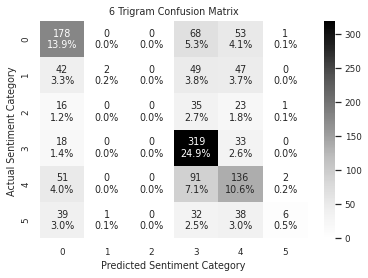

In [32]:
y_pred=clf.best_estimator_.predict(x_test)
y_pred = y_pred.reshape(-1,1)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.1%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(6,6)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greys')

ax.set_title('6 Trigram Confusion Matrix');
ax.set_xlabel('Predicted Sentiment Category')
ax.set_ylabel('Actual Sentiment Category ');

ax.xaxis.set_ticklabels([0,1,2,3,4,5])
ax.yaxis.set_ticklabels([0,1,2,3,4,5])
sns.set(color_codes=True)
sns.set(font_scale=.8)
plt.savefig('6 Trigram Confusion Matrix', bbox_inches = "tight")
plt.show()